In [30]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

figsize=(15, 10)
export_dir = './plots_SP/'
filetype = 'pdf'
env_name = 'stag hunt 5 seed'
data_list = ['sh5s','sh5m','sh5l','sh5o']
env_size = ['Small','Medium','Large','Obstacle']
seeds = 3
total_timestep = 6e6

sns.set()
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor":".93"})

In [31]:
def read_evaluation_data(data_list, size=500, smooth_alpha=0.05):
    full_data_total = pd.DataFrame()
    plot_data_total = pd.DataFrame()

    for _ in np.arange(len(data_list)):
        data_name = data_list[_]
        raw_data = np.load(f'/home/yuxin/meltingpot/MARL/SP_logs/{data_name}.npz')
        timesteps = raw_data['timesteps']
        policy_reward_min = raw_data['policy_reward_min']
        policy_reward_mean = raw_data['policy_reward_mean']
        policy_reward_max = raw_data['policy_reward_max']
        num_seeds = timesteps.shape[0]
        # num_agents = policy_reward_mean.shape[1]
        full_data = pd.DataFrame()
        plot_data = pd.DataFrame()
        count = 0
        for s in range(num_seeds):
            data = pd.DataFrame({'timesteps': timesteps[s,:], 'seeds': np.repeat(s, timesteps.shape[1]), 'env': np.repeat(env_size[_], timesteps.shape[1])})

            data['policy_reward_min'] = policy_reward_min[s,0,:]
            data['policy_reward_mean'] = policy_reward_mean[s,0,:]
            data['policy_reward_max'] = policy_reward_max[s,0,:]
            # remove NaN
            clean_data = data.dropna()

            # smooth data
            for (columnName, columnData) in clean_data.items():
                if columnName != 'timesteps' and columnName != 'seeds' and columnName != 'env':
                    clean_data[f'{columnName}_smooth'] = clean_data[columnName].ewm(alpha=smooth_alpha).mean()

            if count > 0:
                full_data = full_data.loc[full_data.timesteps.isin(clean_data.timesteps)]
                clean_data = clean_data.loc[clean_data.timesteps.isin(full_data.timesteps)]
            full_data = pd.concat([full_data, clean_data], axis=0)

            count += 1
            
        # reduce size for plotting
        count_row = full_data.shape[0] / num_seeds
        reduced_row = []
        for s in range(num_seeds):
            reduced_row.extend(np.linspace(count_row*s, count_row*(s+1)-1, size, dtype=int, endpoint=True).tolist())
        plot_data = full_data.iloc[reduced_row]

        full_data_total = pd.concat([full_data_total, full_data], axis=0)
        plot_data_total = pd.concat([plot_data_total, plot_data], axis=0)
    
    return full_data_total, plot_data_total

In [32]:
full_data, plot_data = read_evaluation_data(data_list, size=500)
plot_data

,timesteps,seeds,env,policy_reward_min,policy_reward_mean,policy_reward_max,policy_reward_min_smooth,policy_reward_mean_smooth,policy_reward_max_smooth
2,4800,0,Small,22.568110,31.118398,39.668687,22.568110,31.118398,39.668687
8,14400,0,Small,15.570085,27.755208,39.933016,19.860009,28.792675,39.754120
14,24000,0,Small,15.570085,27.667059,39.933016,17.524825,28.043980,39.851501
20,33600,0,Small,15.570085,30.255273,56.212698,16.693171,28.884603,46.812456
26,43200,0,Small,15.570085,30.475954,56.212698,16.281449,29.483520,50.258574
...,...,...,...,...,...,...,...,...,...
3099,4960000,4,Obstacle,13.983183,30.689639,51.132826,14.121166,30.896453,49.337738
3105,4969600,4,Obstacle,13.983183,30.440079,51.132826,14.084614,30.817809,49.813271
3111,4979200,4,Obstacle,13.983183,30.350285,51.132826,14.057744,30.675894,50.162832
3117,4988800,4,Obstacle,13.983183,30.144750,51.132826,14.037992,30.553317,50.419791


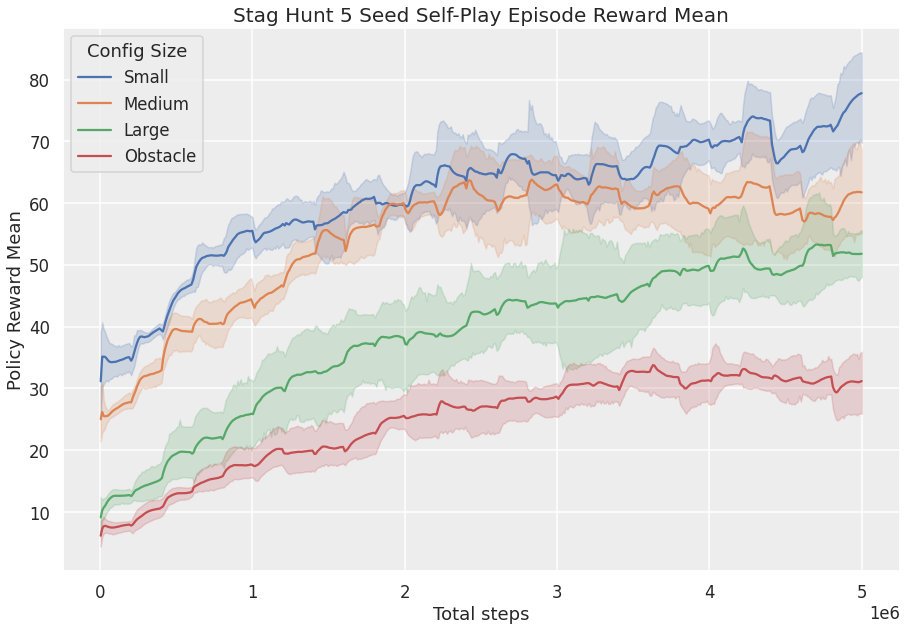

In [33]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=plot_data, x='timesteps', y='policy_reward_mean_smooth', hue='env')
ax.set(xlabel='Total steps', ylabel='Policy Reward Mean')
ax.set_title(env_name.title()+' Self-Play Episode Reward Mean', fontsize=20, y=1.0)
# plt.xticks(np.arange(0, total_timestep, 2e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.legend(title='Config Size')
plt.savefig(os.path.join(export_dir, env_name+' reward mean.'+filetype), bbox_inches='tight')

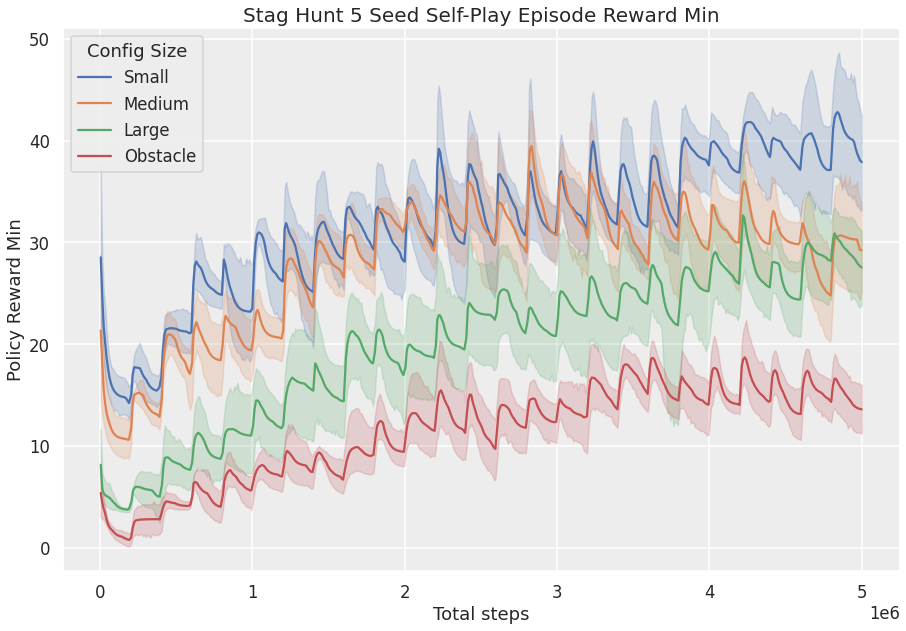

In [34]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=plot_data, x='timesteps', y='policy_reward_min_smooth', hue='env')
ax.set(xlabel='Total steps', ylabel='Policy Reward Min')
ax.set_title(env_name.title()+' Self-Play Episode Reward Min', fontsize=20, y=1.0)
# plt.xticks(np.arange(0, total_timestep, 2e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.legend(title='Config Size')
plt.savefig(os.path.join(export_dir, env_name+' reward min.'+filetype), bbox_inches='tight')

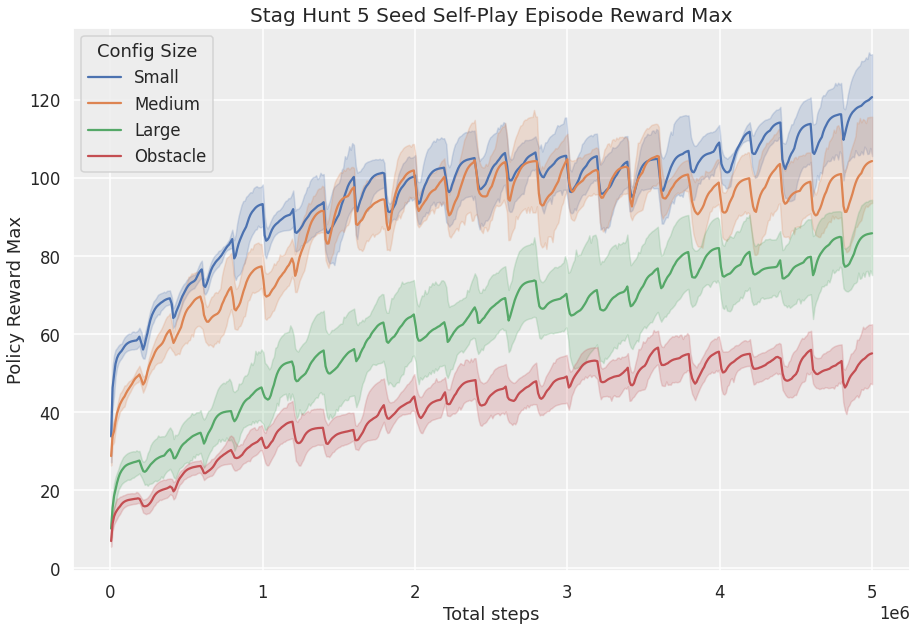

In [35]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=plot_data, x='timesteps', y='policy_reward_max_smooth', hue='env')
ax.set(xlabel='Total steps', ylabel='Policy Reward Max')
ax.set_title(env_name.title()+' Self-Play Episode Reward Max', fontsize=20, y=1.0)
# plt.xticks(np.arange(0, total_timestep, 2e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.legend(title='Config Size')
plt.savefig(os.path.join(export_dir, env_name+' reward max.'+filetype), bbox_inches='tight')